<a href="https://colab.research.google.com/github/LeonMilosevic/fraud_homework_redo/blob/main/fraud_homework_redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept of the Notebook

Notebook will consists out of 5 parts.

1. Analysis
  - Explore the dataset
  - Find insights
  - Draw conclusions
  - Get ideas for feature engineering

2. Base model
  - We will create a base model and have a benchmark for the performence.

3. Feature Engineering
  - Improve the results and build upon discoveries from Analysis part.

4. Modeling
  - Model optimization, and performence tuning.
  - Draw business conclusions

5. Business presentation and final conclusions.
  - We will make a conclusion, sum up all previous chapters, present our solution and advice on how to improve the business model of detecting fraudulent transactions.

# Imports and libraries 

In [ ]:
!pip install pgeocode
!pip install folium
!pip install pycountry
!pip install beautifulsoup4
!pip install catboost

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statistics import mean

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import pycountry
import pgeocode
import folium
from folium import Marker

from scipy import stats

from bs4 import BeautifulSoup
import requests

from helper_functions import get_postal_code, get_time_difference, check_missing_values, split_zip_codes, zip_encoder

import warnings
warnings.filterwarnings('ignore')

# Analysis

In [3]:
transaction_data = pd.read_csv('transactions_obf.csv')
labels_data = pd.read_csv('labels_obf.csv')

# adding target value to labels_data and merging the dataframes
labels_data['target'] = 1
data = pd.merge(transaction_data, labels_data, how="left", on="eventId")

data[['target']] = data[['target']].fillna(value=0)

# converting time column and setting time as index
data['transactionTime'] = pd.to_datetime(data['transactionTime'])

data.shape

(118621, 12)

###### Split into train/test data based on time

In [4]:
train_data = data[data['transactionTime'] < "2018-01-01"]
test_data = data[data['transactionTime'] > "2018-01-01"]

print(train_data.shape)
print(test_data.shape)

(110090, 12)
(8531, 12)


###### Target Distribution

In [5]:
# proportion of fraud transactions
train_data['target'].value_counts(normalize=True)

0.0    0.992406
1.0    0.007594
Name: target, dtype: float64

- We are dealing with class imbalance

###### Total transactions per country

In [6]:
train_data.groupby(['merchantCountry']).target.count().sort_values(ascending=False).head(5)

merchantCountry
826    88908
442    13819
840     2640
372     1236
250      429
Name: target, dtype: int64

We can see that most of the transactions come from Great Britain,
since country code 826 = GB

###### Zip Codes per country

In [7]:
# transform to uppercase as to avoid same values with different cases
train_data['merchantZip'] = train_data['merchantZip'].str.upper()

# getting unique countries values
unique_countries = train_data['merchantCountry'].unique().tolist()

# number of unique zip codes per country
unique_zips = []
for i in unique_countries:
  unique_zips.append(len(train_data.loc[train_data['merchantCountry'] == i]['merchantZip'].unique()))

temp_data = {"country_code": unique_countries, "num_of_unique_zip_codes": unique_zips}
zip_codes_per_country_df = pd.DataFrame(temp_data)
zip_codes_per_country_df.head(5)

,country_code,num_of_unique_zip_codes
0,826,3099
1,442,1
2,392,1
3,36,1
4,372,1


In [8]:
len(train_data['merchantZip'].unique())

3100

We can see that all merchant zip codes come from Great Britain, while zip codes from countries other than GB were not registered or are unknown.

###### Taking a closer look at GB

In [9]:
gb_data = train_data.loc[train_data['merchantCountry'] == 826]

# total unique number of strings lengths for zip codes
zip_lengths = len(gb_data['merchantZip'].str.len().value_counts().index.to_list())

# number of unique zip code values based on their length
for i in range(zip_lengths):
  print(i+1, len(gb_data.loc[gb_data['merchantZip'].str.len() == i+1]['merchantZip'].unique()))

1 2
2 4
3 1087
4 1263
5 743


**Note:** Zip Code Fact 1.0

* Zip code pattern for GB is letter+digit

###### Invalid Zip codes, based on Zip Code Fact 1.0

In [10]:
# finding non alpha numeric values
non_alpha_numeric = gb_data[gb_data['merchantZip'].str.contains('(\W+)')]['merchantZip'].unique().tolist()

# finding values that only contain digits
only_numeric = gb_data[gb_data['merchantZip'].str.contains('^([\s\d]+)$')]['merchantZip'].unique().tolist()

# finding values that only contain alphabetic chars
only_alphabetic_chars = gb_data[gb_data['merchantZip'].str.contains('^[a-zA-Z]+$')]['merchantZip'].unique().tolist()

invalid_zip_values = non_alpha_numeric + only_numeric + only_alphabetic_chars

In [11]:
invalid_zip_values[:5]

['....', '...', '***', '.....', '**']

###### Number of transactions for each invalid zip code

In [12]:
invalid_zip_transactions = []
for zip in invalid_zip_values:
  invalid_zip_transactions.append(gb_data.loc[gb_data['merchantZip'] == zip].shape[0])

temp_data = {"zip_codes": invalid_zip_values, "transactions": invalid_zip_transactions}
df = pd.DataFrame(temp_data)

df.sort_values(by=['transactions'], ascending=False).head(5)

,zip_codes,transactions
6,0,13554
1,...,374
0,....,361
7,11111,35
19,F,27


In [13]:
# count of transactions for valid + invalid zip values
gb_data.groupby(['merchantZip']).count().target.sort_values(ascending=False)

merchantZip
0        13554
E12       1063
SL4        614
LS11       570
CO10       512
         ...  
E83NS        1
E83DG        1
E82NS        1
E82JP        1
YO8          1
Name: target, Length: 3099, dtype: int64

Given that merchantZip "0" has the highest number of transactions in GB, we can't assume that it is coming from one/same location. We should then encode it as a geolocation from GB.

**Note:** Zip Code Fact 1.1

* All codes in GB that have 5 characters, have space before 3rd character

###### Fixing zip codes based on Zip Code Fact 1.1

In [14]:
gb_data['merchantZip'] = split_zip_codes(gb_data, 5)

###### Adding longitude and latitude to each sample based on Zip address

In [15]:
nomi = pgeocode.Nominatim('gb')

# encoding known zip codes
gb_zip_codes = pd.DataFrame({"zip_codes": gb_data['merchantZip'].unique()})

gb_zip_codes[['Latitude', 'Longitude', 'state_name']] = gb_zip_codes.apply(lambda x: get_postal_code(nomi, x['zip_codes']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(gb_zip_codes["Latitude"])) / len(gb_zip_codes)) * 100))

95.70829299774121% of addresses were geocoded!


In [16]:
not_found_zip_codes = gb_zip_codes[gb_zip_codes['Latitude'].isnull()]
not_found_zip_codes['zip_codes'].str.len().value_counts()

4    70
3    41
6    16
2     4
1     2
Name: zip_codes, dtype: int64

After manually examining some codes, most of them are districts with missing street numbers or the codes are no longer in use.

* There are some geopy maps that could potentionally find the geolocation of a district, unfortunatelly, free-tier maps do not work well with districts or not in use post-codes.

* We will encode all the non-found zip_codes with geolocation of GB

* Countries other than GB, since they are missing merchantZip, will be encoded by their country Long/Lat

###### Account number exploration

In [26]:
# repeated transactions
train_data[train_data['target'] == 1]['accountNumber'].value_counts()[:20]

8b9c15ea    97
3ec9dda7    59
6bab7602    48
39219923    45
7728d696    41
1602df4e    41
0646d69d    24
749acd16    24
bd9f22c1    18
50a66385    16
ab09dc29    14
3c971982    10
c8e8e50e    10
3e772d6b     9
6c8aab9a     9
f42ba1f1     8
23ce118b     7
5576aade     7
6c319a1d     6
accd8410     6
Name: accountNumber, dtype: int64

- We can see repeated transactions coming from same accounts, we will explore later in what interval of time fraud transactions happen.

###### Explore PosEntryMode

In [27]:
train_data['posEntryMode'].value_counts()

5     65262
81    33189
1      9875
90     1047
7       569
80       91
79       31
2        13
0        10
91        3
Name: posEntryMode, dtype: int64

In [28]:
train_data[train_data['target'] == 1]['posEntryMode'].value_counts()

81    618
1     188
5      17
90      9
2       2
0       2
Name: posEntryMode, dtype: int64

Most of the transactions come from POS Entry Circuit Card, and most fraudulent transactions come from POS Entry E-Commerce

###### Exploring Time

Difference in median time between given accounts with fraudulent transactions and non-fraudulent transactions.

In [29]:
# median time of fraudulent transactions by account number
fraud_time_med = []

for account in train_data[train_data['target']==1]['accountNumber'].unique().tolist():
  acc_time = get_time_difference(train_data, 'accountNumber', account, 'transactionTime', 1)
  if len(acc_time) == 0:
    fraud_time_med.append(0)
  else:
    fraud_time_med.append(np.median(acc_time))

# median time of non-fraudulent transactions by account number
non_fraud_time_med = []

for account in train_data[train_data['target'] == 0]['accountNumber'].unique().tolist():
  acc_time = get_time_difference(train_data, 'accountNumber', account, 'transactionTime', 0)
  if len(acc_time) == 0:
    non_fraud_time_med.append(0)
  else:
    non_fraud_time_med.append(np.median(acc_time))

In [30]:
print(f'fraud: {np.median(fraud_time_med)}')
print(f'not-fraud: {np.median(non_fraud_time_med)}')

fraud: 13.958333333333332
not-fraud: 8012.758333333333


Fraud transactions happen in a shorter span of time then regular ones.

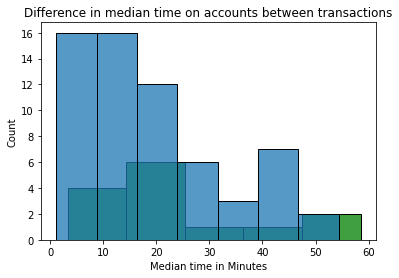

In [31]:
# comparing distribution between fraud and non-fraud transactions within the first hour
ax = sns.histplot([i for i in non_fraud_time_med if i != 0 and i < 60], color='green')
sns.histplot([i for i in fraud_time_med if i != 0 and i < 60])
ax.set(xlabel='Median time in Minutes', ylabel='Count', title='Difference in median time on accounts between transactions')
plt.show()

From this plot we can see that fraudulent transactions happen consecutively more often in the first 15 minutes than legitimate transactions.

A good business decision would be to block the card if more than 4-5 consecutive transactions happen in the first 5-10 minutes, until client can confirm transactions over the app, or via call from customer support agent. For example.

###### Exploring continues variables

In [32]:
print(f"fraud median: {train_data[train_data['target'] == 1]['transactionAmount'].median()}")
print(f"non-fraud median: {train_data[train_data['target'] == 0]['transactionAmount'].median()}")

fraud median: 21.0
non-fraud median: 20.32


In [33]:
print(f"fraud median: {train_data[train_data['target'] == 1]['availableCash'].median()}")
print(f"non-fraud median: {train_data[train_data['target'] == 0]['availableCash'].median()}")

fraud median: 4500.0
non-fraud median: 7500.0


We can spot a difference in available cash amount between fraud and non-fraud transactions. 

In [20]:
url = "https://developers.google.com/public-data/docs/canonical/countries_csv"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

df_test = zip_encoder(data, pgeocode, pycountry, soup)

# Baseline Model

In [54]:
x_train = data[data['transactionTime'] < '2017-12-01'].drop(['reportedTime', 'target', 'eventId'], axis=1).fillna('unknown')
y_train = data[data['transactionTime'] < '2017-12-01']['target']

x_valid = data[data['transactionTime'] > '2017-12-01'].drop(['reportedTime', 'target', 'eventId'], axis=1).fillna('unknown')
y_valid = data[data['transactionTime'] > '2017-12-01']['target']

In [60]:
y_valid.value_counts()

0.0    17574
1.0       83
Name: target, dtype: int64

In [58]:
x_valid

,transactionTime,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
100964,2017-12-01 00:21:45+00:00,414a54aa,4fd0ff,5735,442,unknown,81,7.47,11500
100965,2017-12-01 00:34:39+00:00,b9b98bc8,e7d776,5411,826,SO30,5,16.69,8500
100966,2017-12-01 00:32:34+00:00,79c36e79,bdc20d,5211,826,BH8,5,22.08,7500
100967,2017-12-01 00:11:50+00:00,67e26790,02db45,4214,826,TA21,1,200.70,4500
100968,2017-12-01 00:34:15+00:00,5715dce1,ed5960,5331,826,CB8,5,40.03,10500
...,...,...,...,...,...,...,...,...,...
118616,2018-01-30 23:52:16+00:00,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500
118617,2018-01-30 23:57:16+00:00,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500
118618,2018-01-30 23:59:03+00:00,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500
118619,2018-01-31 00:04:44+00:00,ec212849,1ab20c,4812,826,SL1,1,11.00,7500


In [55]:
cat_features = ['accountNumber', 'merchantId', 'mcc', 'merchantCountry', 'merchantZip', 'posEntryMode']

cbc = CatBoostClassifier(
    random_seed=42,
    verbose=100,
)

cbc.fit(x_train, y_train, cat_features = cat_features)  

Learning rate set to 0.073912
0:	learn: 0.5311148	total: 190ms	remaining: 3m 9s
100:	learn: 0.0140198	total: 13s	remaining: 1m 55s
200:	learn: 0.0123758	total: 27.2s	remaining: 1m 48s
300:	learn: 0.0112458	total: 41.2s	remaining: 1m 35s
400:	learn: 0.0101686	total: 55.9s	remaining: 1m 23s
500:	learn: 0.0094114	total: 1m 10s	remaining: 1m 10s
600:	learn: 0.0087465	total: 1m 24s	remaining: 56.3s
700:	learn: 0.0081013	total: 1m 38s	remaining: 42.2s
800:	learn: 0.0075707	total: 1m 53s	remaining: 28.3s
900:	learn: 0.0070323	total: 2m 9s	remaining: 14.2s
999:	learn: 0.0065474	total: 2m 24s	remaining: 0us


In [67]:
confusion_matrix(y_valid, cbc.predict(x_valid))

array([[17563,    11],
       [   82,     1]])

In [64]:
cbc.predict(x_valid)

array([0., 0., 0., ..., 0., 0., 0.])

In [66]:
roc_auc_score(y_valid, cbc.predict(x_valid))

0.5057111340548263